# **Capstone Project - Decent and Indecent Clothes Classification Model**

**Team ID** : C241-PS306

**Anggota** :

*   Muhammad Farhan Akmal (M012D4KY2187)
*   Gibran Ariq Natakusuma (M012D4KY2405)
*   Muthia Rasikha Zahra (M299D4KX1388)






## **Importing Required Libraries**

In [1]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Splitting Dataset**

In [4]:
# !pip install split-folders

In [5]:
# import splitfolders

# # Input folder containing 'decent' and 'indecent' subfolders
# input_folder = "/content/drive/MyDrive/Dataset_Bangkit/data"

# # Output folder where the split data will be stored
# output_folder = "/content/drive/MyDrive/Dataset_Bangkit/data_split2"

# # Split with a ratio of 80:20
# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.2), group_prefix=None)

## **Model Creation**

### **Set Paths**

In [6]:
# Define paths
train_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_split/train'
val_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_split/val'

### **Augmenting Data**

In [7]:
def train_val_generators(train_dir, val_dir):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)


    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(256, 256),
      batch_size=32,
      class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 802 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


(32, 256, 256, 3)


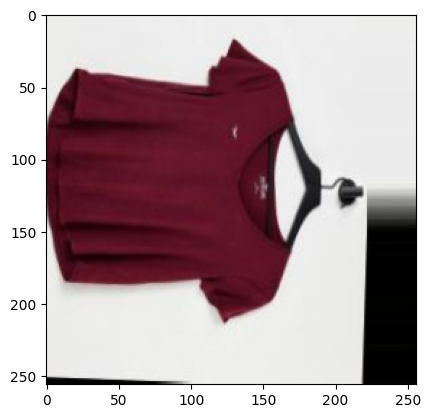

(32, 256, 256, 3)


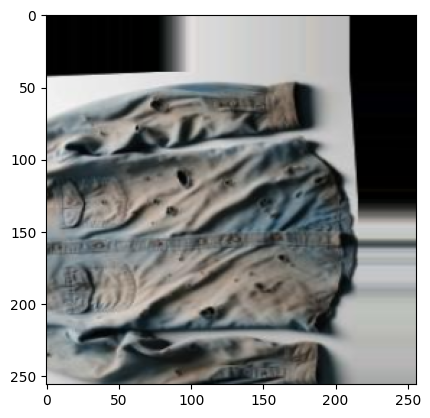

(32, 256, 256, 3)


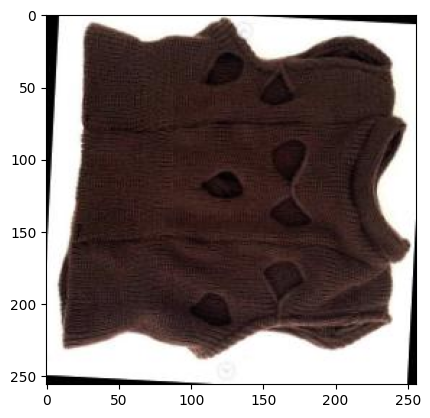

(32, 256, 256, 3)


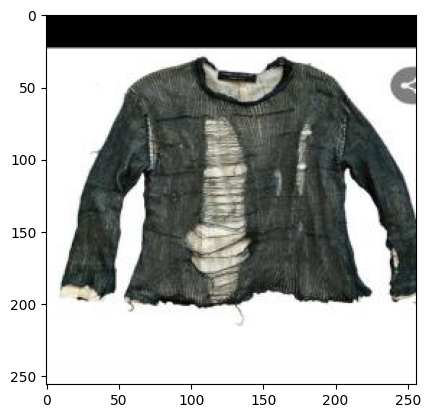

In [9]:
for _ in range(2):
    img, label = train_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

for _ in range(2):
    img, label = validation_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

In [10]:
# Get the class details
class_details = validation_generator.class_indices

# Print the class details
for class_name, class_index in class_details.items():
    print("Class:", class_name)
    print("Index:", class_index)


Class: decent
Index: 0
Class: indecent
Index: 1


### **Creating the Base Model**

In [11]:
def create_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### **Using Callbacks**

In [12]:
# Add custom callback to stop after accuracy > 99%
class EarlyStoppingByAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy > 0.99:
            print(f"\nAccuracy reached {accuracy * 100:.2f}%, stopping training.")
            self.model.stop_training = True

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min'),
    EarlyStoppingByAccuracy()
]

### **Using Pretrained MobileNetV2 Model**

In [14]:
base_model_mobilenet = MobileNetV2(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_mobilenet.layers:
  layer.trainable = False
base_model_mobilenet.summary()
model_mobilenet = create_model(base_model_mobilenet)
model_mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [15]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - 317s 13s/step - loss: 0.7682 - accuracy: 0.5195 - val_loss: 0.7645 - val_accuracy: 0.4938 - lr: 1.0000e-04
Epoch 2/50
25/25 [==============================] - 18s 692ms/step - loss: 0.6925 - accuracy: 0.5818 - val_loss: 0.7084 - val_accuracy: 0.5219 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - 16s 678ms/step - loss: 0.6473 - accuracy: 0.5974 - val_loss: 0.6624 - val_accuracy: 0.5969 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - 17s 696ms/step - loss: 0.6116 - accuracy: 0.6506 - val_loss: 0.6155 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - 17s 693ms/step - loss: 0.5751 - accuracy: 0.6948 - val_loss: 0.5830 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 6/50
25/25 [==============================] - 17s 715ms/step - loss: 0.5360 - accuracy: 0.7506 - val_loss: 0.5503 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 7/50
25/25 [=======================

In [16]:
loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")

10/10 [==============================] - 2s 144ms/step - loss: 0.2282 - accuracy: 0.9250
MobileNetV2 Validation Accuracy: 92.50%


### **Using Pretrained InceptionV3 Model**

In [17]:
base_model_inception = InceptionV3(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_inception.layers:
  layer.trainable = False
base_model_inception.summary()
model_inception = create_model(base_model_inception)

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [18]:
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - 26s 753ms/step - loss: 0.7201 - accuracy: 0.5364 - val_loss: 0.6785 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/50
25/25 [==============================] - 18s 728ms/step - loss: 0.6886 - accuracy: 0.5600 - val_loss: 0.6425 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - 18s 702ms/step - loss: 0.6524 - accuracy: 0.6104 - val_loss: 0.6174 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - 17s 663ms/step - loss: 0.6231 - accuracy: 0.6442 - val_loss: 0.5843 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - 16s 654ms/step - loss: 0.5908 - accuracy: 0.6896 - val_loss: 0.5640 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 6/50
25/25 [==============================] - 17s 660ms/step - loss: 0.5613 - accuracy: 0.7208 - val_loss: 0.5385 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 7/50
25/25 [======================

In [19]:
loss_inception, accuracy_inception = model_inception.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

10/10 [==============================] - 2s 136ms/step - loss: 0.2520 - accuracy: 0.9187
InceptionV3 Validation Accuracy: 91.87%


### **Comparing the Results**

MobileNetV2 Validation Accuracy: 92.19%
InceptionV3 Validation Accuracy: 92.81%


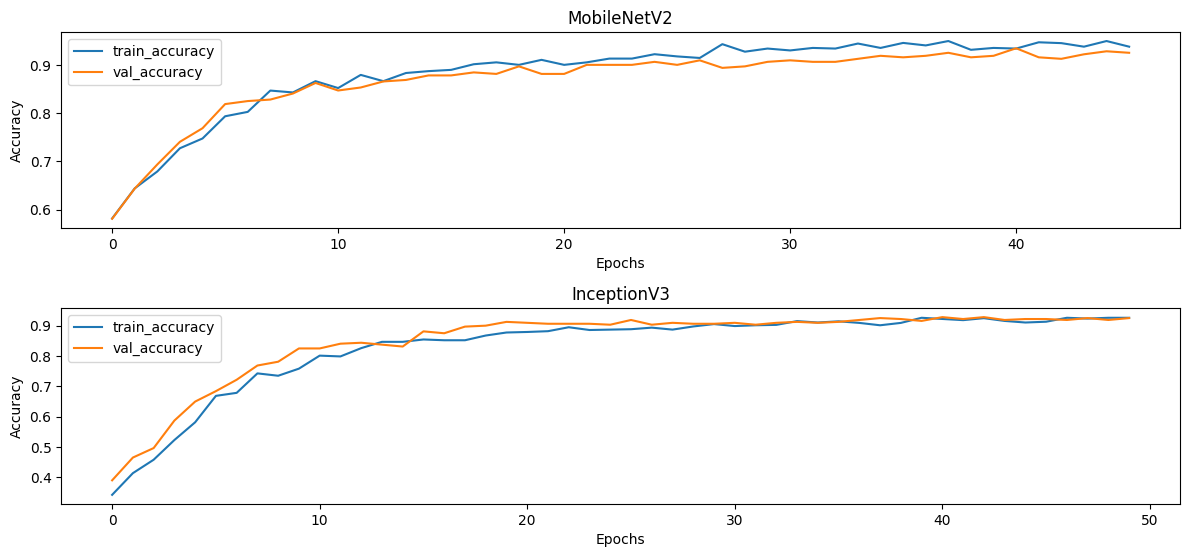

In [ ]:
# Print out the validation accuracies
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

# Plot the training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(3, 1, i+1)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(titles[i])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history_mobilenet, history_inception],
             ['MobileNetV2', 'InceptionV3'])


## **Export Model**

### **Export Model h5**


In [20]:
model_mobilenet.save('/content/drive/MyDrive/ml_results/mobilenet/my_model')
model_mobilenet.save_weights('/content/drive/MyDrive/ml_results/mobilenet/my_weight')

tf.saved_model.save(
  model_mobilenet, '/content/drive/MyDrive/ml_results/mobilenet/my_model/my_model_saved_model')

In [21]:
tf.keras.models.save_model(model_mobilenet, '/content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_mobilenet.h5') # Saving the Model in H5 Format

<ipython-input-21-d53039c41f87>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_mobilenet, '/content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_mobilenet.h5') # Saving the Model in H5 Format


In [22]:
model_inception.save('/content/drive/MyDrive/ml_results/inception/my_model')
model_inception.save_weights('/content/drive/MyDrive/ml_results/inception/my_weight')

tf.saved_model.save(
  model_inception, '/content/drive/MyDrive/ml_results/inception/my_model/my_model_saved_model')

In [23]:
tf.keras.models.save_model(model_mobilenet, '/content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_inception.h5') # Saving the Model in H5 Format

<ipython-input-23-0d2e510fce33>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_mobilenet, '/content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_inception.h5') # Saving the Model in H5 Format


### Export as .json and bin files

In [24]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
  

In [ ]:
# Convert the Keras model to TensorFlow.js format
!tensorflowjs_converter --input_format keras /content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_mobilenet.h5 /content/drive/MyDrive/ml_results/tfjs/mobilenet/

!tensorflowjs_converter --input_format keras /content/drive/MyDrive/ml_results/hdf5/decent_indecent_detection_inception.h5 /content/drive/MyDrive/ml_results/tfjs/inception/
